# 0. 기본 정보
* 코드 작성자: 여서연
* 코드 작성일: 2024-11-20
* 코드 작성 목적: NLP 및 LDA 토픽 모델링

## 참조 코드 - Topic Modeling using LDA

* https://joyhong.tistory.com/138
* https://github.com/FifthSaint/NewsTextMining201903
* https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
* https://github.com/fastai/course-nlp/blob/master/2-svd-nmf-topic-modeling.ipynb

# 1. 기초 설정

## 사용 라이브러리

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from konlpy.tag import *

In [3]:
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

In [4]:
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

In [5]:
import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 처리

## A. 크롤링 데이터 불러오기

In [6]:
# 10월 1일부터 11월 15일까지 데이터를 읽어오기
for month, start, end in [(10, 1, 31), (11, 1, 15)]:  # 10월 1~31일, 11월 1~15일
    for day in range(start, end + 1):
        file_path = f'../data/속보 한강 노벨_2024{str(month).zfill(2)}{str(day).zfill(2)}_news_data.csv'
        variable_name = f'day_{(month - 10) * 31 + day}'  # 10월 1일부터 순차적으로 day_1 ~ day_46

        if os.path.exists(file_path):  # 파일 존재 여부 확인
            try:
                # 파일 크기 확인 (비어있는 경우 처리)
                if os.path.getsize(file_path) > 0:
                    data = pd.read_csv(file_path)
                    globals()[variable_name] = data if not data.empty else None
                else:
                    globals()[variable_name] = None
            except pd.errors.EmptyDataError:
                print(f"{file_path} 파일이 비어있습니다.")
                globals()[variable_name] = None
            except Exception as e:
                print(f"{file_path} 파일을 읽는 중 오류가 발생했습니다: {e}")
                globals()[variable_name] = None
        else:
            globals()[variable_name] = None

../data/속보 한강 노벨_20241001_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241002_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241003_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241004_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241005_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241006_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241007_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241008_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241009_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241020_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241102_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241103_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241105_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241107_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241108_news_data.csv 파일이 비어있습니다.
../data/속보 한강 노벨_20241109_news_data.csv 파일이 비어있습니다.
../data/

In [7]:
print(f'<day_1>: \n{day_1}')
print()
print(f'<day_10>: \n{day_10}')

<day_1>: 
None

<day_10>: 
                                          Title         Date       Press  \
0                             [속보]노벨문학상에 소설가 한강  2024.10.10.  경향신문언론사 선정   
1                  [속보] 노벨문학상 한강 "매우 놀랍고 영광스럽다"  2024.10.10.  연합뉴스언론사 선정   
2                   [속보] 소설가 한강, 한국 첫 노벨 문학상 쾌거  2024.10.10.  매일경제언론사 선정   
3                 [영상] “온몸에 소름”…한강 노벨문학상에 시민 환호  2024.10.10.   한겨레언론사 선정   
4                 한강 노벨상에 정쟁 멈추고, 온라인 서점 마비사태까지  2024.10.10.  매일경제언론사 선정   
..                                          ...          ...         ...   
124  [속보] 한강 소설가가 한국 작가 최초로 노벨 문학상을 수상하는 쾌거를...  2024.10.10.    허프포스트코리아   
125         [속보] '채식주의자' 작가 한강, 한국인 첫 노벨 문학상 수상  2024.10.10.        비건뉴스   
126              [속보] 한국 첫 노벨 문학상…'채식주의자' 작가 한강  2024.10.10.      전국매일신문   
127                    경사 맞은 문단·출판계···한국문학 붐 기대       A2면 1단        경향신문   
128           윤 대통령 “위대한 업적이자 온 국민이 기뻐할 국가적 경사”  2024.10.10.        경향신문   

                                           Description  
0  

In [8]:
# day_x 변수들 중 실제 데이터프레임만 선택
dataframes = [df for var_name, df in globals().items()
              if var_name.startswith('day_') and isinstance(df, pd.DataFrame)]

In [9]:
print(dataframes)

[                                          Title         Date       Press  \
0                             [속보]노벨문학상에 소설가 한강  2024.10.10.  경향신문언론사 선정   
1                  [속보] 노벨문학상 한강 "매우 놀랍고 영광스럽다"  2024.10.10.  연합뉴스언론사 선정   
2                   [속보] 소설가 한강, 한국 첫 노벨 문학상 쾌거  2024.10.10.  매일경제언론사 선정   
3                 [영상] “온몸에 소름”…한강 노벨문학상에 시민 환호  2024.10.10.   한겨레언론사 선정   
4                 한강 노벨상에 정쟁 멈추고, 온라인 서점 마비사태까지  2024.10.10.  매일경제언론사 선정   
..                                          ...          ...         ...   
124  [속보] 한강 소설가가 한국 작가 최초로 노벨 문학상을 수상하는 쾌거를...  2024.10.10.    허프포스트코리아   
125         [속보] '채식주의자' 작가 한강, 한국인 첫 노벨 문학상 수상  2024.10.10.        비건뉴스   
126              [속보] 한국 첫 노벨 문학상…'채식주의자' 작가 한강  2024.10.10.      전국매일신문   
127                    경사 맞은 문단·출판계···한국문학 붐 기대       A2면 1단        경향신문   
128           윤 대통령 “위대한 업적이자 온 국민이 기뻐할 국가적 경사”  2024.10.10.        경향신문   

                                           Description  
0    스웨덴 한림원은 2024년 노벨 문학상 수상

In [10]:
articles = pd.concat(dataframes, ignore_index=True)
articles

,Title,Date,Press,Description
0,[속보]노벨문학상에 소설가 한강,2024.10.10.,경향신문언론사 선정,스웨덴 한림원은 2024년 노벨 문학상 수상자로 한강 작가를 선정했다고 10일(현지...
1,"[속보] 노벨문학상 한강 ""매우 놀랍고 영광스럽다""",2024.10.10.,연합뉴스언론사 선정,NaN
2,"[속보] 소설가 한강, 한국 첫 노벨 문학상 쾌거",2024.10.10.,매일경제언론사 선정,올해 노벨 문학상의 영예는 우리나라 소설가 한강에게 돌아갔다. 한국인이 노벨상을 수...
3,[영상] “온몸에 소름”…한강 노벨문학상에 시민 환호,2024.10.10.,한겨레언론사 선정,20대 여성 이연재씨는 “퇴근 후 대학 친구들이 단체대화방에 한강의 노벨문학상 수상...
4,"한강 노벨상에 정쟁 멈추고, 온라인 서점 마비사태까지",2024.10.10.,매일경제언론사 선정,외신들도 일제히 한강의 노벨문학상 수상을 속보로 다루며 ‘아시아 소설의 새로운 얼굴...
...,...,...,...,...
270,[발행인 칼럼] 한강의 기적과 '독서신문'의 54년,2주 전,독서신문,한강 작가가 2024년 노벨문학상 수상자로 호명된 뒤 많은 것이 변했다. 속보 기사...
271,[시선2035] 위태로운 ‘다윗과 골리앗’,A24면 1단,중앙일보,"저녁 8시 2분, 갑자기 날아든 속보로 공기는 확 달라졌다. ‘[1보] 노벨 문학상..."
272,서랍에 저녁을 넣어 두었다,1주 전,충청타임즈,"번역이라는 큰 벽이 존재하는 이상, 사용자가 많은 중국과 인도, 이미 두 번의 노벨..."
273,"[도민시론┃문화·예술]자연스럽게 한발 멈춰, 숨",19면 1단,강원도민일보,한강 작가의 노벨상 수상과 그의 문학이 거지 같은 뉴스들을 덮어 버려 살 것 같다....


In [11]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        275 non-null    object
 1   Date         275 non-null    object
 2   Press        275 non-null    object
 3   Description  258 non-null    object
dtypes: object(4)
memory usage: 8.7+ KB


In [12]:
filtered_articles = articles.dropna(subset=['Description']).reset_index(drop=True)
filtered_articles

,Title,Date,Press,Description
0,[속보]노벨문학상에 소설가 한강,2024.10.10.,경향신문언론사 선정,스웨덴 한림원은 2024년 노벨 문학상 수상자로 한강 작가를 선정했다고 10일(현지...
1,"[속보] 소설가 한강, 한국 첫 노벨 문학상 쾌거",2024.10.10.,매일경제언론사 선정,올해 노벨 문학상의 영예는 우리나라 소설가 한강에게 돌아갔다. 한국인이 노벨상을 수...
2,[영상] “온몸에 소름”…한강 노벨문학상에 시민 환호,2024.10.10.,한겨레언론사 선정,20대 여성 이연재씨는 “퇴근 후 대학 친구들이 단체대화방에 한강의 노벨문학상 수상...
3,"한강 노벨상에 정쟁 멈추고, 온라인 서점 마비사태까지",2024.10.10.,매일경제언론사 선정,외신들도 일제히 한강의 노벨문학상 수상을 속보로 다루며 ‘아시아 소설의 새로운 얼굴...
4,"[속보] 소설가 한강, 한국인 첫 노벨 문학상 수상",2024.10.10.,문화일보언론사 선정,2024년 노벨 문학상의 영예가 우리나라 소설가 한강에게 돌아갔다. 한국인이 노벨상...
...,...,...,...,...
253,[발행인 칼럼] 한강의 기적과 '독서신문'의 54년,2주 전,독서신문,한강 작가가 2024년 노벨문학상 수상자로 호명된 뒤 많은 것이 변했다. 속보 기사...
254,[시선2035] 위태로운 ‘다윗과 골리앗’,A24면 1단,중앙일보,"저녁 8시 2분, 갑자기 날아든 속보로 공기는 확 달라졌다. ‘[1보] 노벨 문학상..."
255,서랍에 저녁을 넣어 두었다,1주 전,충청타임즈,"번역이라는 큰 벽이 존재하는 이상, 사용자가 많은 중국과 인도, 이미 두 번의 노벨..."
256,"[도민시론┃문화·예술]자연스럽게 한발 멈춰, 숨",19면 1단,강원도민일보,한강 작가의 노벨상 수상과 그의 문학이 거지 같은 뉴스들을 덮어 버려 살 것 같다....


In [13]:
docs = []
for idx in range(len(filtered_articles)):
    docs.append(filtered_articles['Description'][idx])

In [14]:
docs

['스웨덴 한림원은 2024년 노벨 문학상 수상자로 한강 작가를 선정했다고 10일(현지시간) 발표했다. 한국인이 노벨상을 수상한 것은 지난 2000년 평화상을 탄 고(故) 김대중 전 대통령에 이어 두번째다. 한강 작가의 수상으로 한국은 노벨 문학상 수상의 첫 쾌거를 얻었다. 수상자에게는 상금 1100만 크로나(약...',
 '올해 노벨 문학상의 영예는 우리나라 소설가 한강에게 돌아갔다. 한국인이 노벨상을 수상한 것은 지난 2000년 평화상을 탄 고(故) 김대중 전 대통령에 이어 두번째다. 10일(현지시간) 스웨덴 한림원은 이같은 결과를 발표했다. 수상자에게는 상금 1100만 크로나(약 13억4000만원)와 메달, 증서가 수여된다....',
 '20대 여성 이연재씨는 “퇴근 후 대학 친구들이 단체대화방에 한강의 노벨문학상 수상 속보 기사를 올려서 알게 됐다“며 “단체대화방에서 친구들이 ‘미쳤다’고 외치는 중”이라고 전했다. 이씨는 또 “어렸을 때부터 맨날 남성 작가들만 노벨문학상 후보에 이름을 올렸다는 기사를 읽다가 여성 작가가...',
 '외신들도 일제히 한강의 노벨문학상 수상을 속보로 다루며 ‘아시아 소설의 새로운 얼굴’에 열광했다. AP통신은 이날 스웨덴 한림원이 한강을 노벨 문학상 수상자로 발표하자 이 소식을 긴급 뉴스로 전했다. AP통신은 한강이 2016년 육식을 거부하기로 한 여성의 이야기를 그린 소설 ‘채식주의자’로 맨부커...',
 '2024년 노벨 문학상의 영예가 우리나라 소설가 한강에게 돌아갔다. 한국인이 노벨상을 수상한 것은 지난 2000년 평화상을 탄 고(故) 김대중 전 대통령에 이어 두번째다. 스웨덴 한림원은 10일(현지시간) 이같은 결과를 발표했다. 수상자에게는 상금 1100만 크로나(약 13억4000만 원)와 메달, 증서가 수여된다....',
 '스웨덴 한림원은 10일(현지 시각) 소설가 한강이 2024년 노벨문학상 수상자로 선정됐다고 발표했다. 스웨덴 한림원은 선정 이유로 “역사의 트라우마에 맞서는 동시에 인간 생의 연약함을 드러내는

## B. 구두점 처리

In [15]:
# 제거할 문자와 그 대체값을 딕셔너리로 정의
remove_dict = {
    '.': ' ',   # 마침표 제거
    ',': ' ',   # 쉼표 제거
    "'": ' ',   # 작은따옴표 제거
    '"': ' ',   # 큰따옴표 제거
    '·': ' ',  # 중간 점을 공백으로 대체
    '=': ' ',   # 등호 제거
    '\\n': ' ',  # 개행 문자 제거
    '[': ' ',
    ']': ' ',
    '(': ' ',
    ')': ' ',
    '…': ' ',
    '\\': ' '
}

In [16]:
# 여러 문자 제거를 위한 함수 생성
def CleanText(text, remove_dict):
    for key, value in remove_dict.items():
        text = text.replace(key, value)
    return text

In [17]:
doc_set = []
for doc in docs:
    doc_set.append(CleanText(doc, remove_dict))

In [18]:
doc_set

['스웨덴 한림원은 2024년 노벨 문학상 수상자로 한강 작가를 선정했다고 10일 현지시간  발표했다  한국인이 노벨상을 수상한 것은 지난 2000년 평화상을 탄 고 故  김대중 전 대통령에 이어 두번째다  한강 작가의 수상으로 한국은 노벨 문학상 수상의 첫 쾌거를 얻었다  수상자에게는 상금 1100만 크로나 약   ',
 '올해 노벨 문학상의 영예는 우리나라 소설가 한강에게 돌아갔다  한국인이 노벨상을 수상한 것은 지난 2000년 평화상을 탄 고 故  김대중 전 대통령에 이어 두번째다  10일 현지시간  스웨덴 한림원은 이같은 결과를 발표했다  수상자에게는 상금 1100만 크로나 약 13억4000만원 와 메달  증서가 수여된다    ',
 '20대 여성 이연재씨는 “퇴근 후 대학 친구들이 단체대화방에 한강의 노벨문학상 수상 속보 기사를 올려서 알게 됐다“며 “단체대화방에서 친구들이 ‘미쳤다’고 외치는 중”이라고 전했다  이씨는 또 “어렸을 때부터 맨날 남성 작가들만 노벨문학상 후보에 이름을 올렸다는 기사를 읽다가 여성 작가가   ',
 '외신들도 일제히 한강의 노벨문학상 수상을 속보로 다루며 ‘아시아 소설의 새로운 얼굴’에 열광했다  AP통신은 이날 스웨덴 한림원이 한강을 노벨 문학상 수상자로 발표하자 이 소식을 긴급 뉴스로 전했다  AP통신은 한강이 2016년 육식을 거부하기로 한 여성의 이야기를 그린 소설 ‘채식주의자’로 맨부커   ',
 '2024년 노벨 문학상의 영예가 우리나라 소설가 한강에게 돌아갔다  한국인이 노벨상을 수상한 것은 지난 2000년 평화상을 탄 고 故  김대중 전 대통령에 이어 두번째다  스웨덴 한림원은 10일 현지시간  이같은 결과를 발표했다  수상자에게는 상금 1100만 크로나 약 13억4000만 원 와 메달  증서가 수여된다    ',
 '스웨덴 한림원은 10일 현지 시각  소설가 한강이 2024년 노벨문학상 수상자로 선정됐다고 발표했다  스웨덴 한림원은 선정 이유로 “역사의 트라우마에 맞서는 동시에 인간 생의 연약함을 드러내는

## C. 불용어 및 자연어 처리

In [19]:
terms = []

In [20]:
ranksnl_stopword = '''아
휴
아이구
아이쿠
아이고
어
나
우리
저희
따라
의해
을
를
에
의
가
으로
로
에게
뿐이다
의거하여
근거하여
입각하여
기준으로
예하면
예를 들면
예를 들자면
저
소인
소생
저희
지말고
하지마
하지마라
다른
물론
또한
그리고
비길수 없다
해서는 안된다
뿐만 아니라
만이 아니다
만은 아니다
막론하고
관계없이
그치지 않다
그러나
그런데
하지만
든간에
논하지 않다
따지지 않다
설사
비록
더라도
아니면
만 못하다
하는 편이 낫다
불문하고
향하여
향해서
향하다
쪽으로
틈타
이용하여
타다
오르다
제외하고
이 외에
이 밖에
하여야
비로소
한다면 몰라도
외에도
이곳
여기
부터
기점으로
따라서
할 생각이다
하려고하다
이리하여
그리하여
그렇게 함으로써
하지만
일때
할때
앞에서
중에서
보는데서
으로써
로써
까지
해야한다
일것이다
반드시
할줄알다
할수있다
할수있어
임에 틀림없다
한다면
등
등등
제
겨우
단지
다만
할뿐
딩동
댕그
대해서
대하여
대하면
훨씬
얼마나
얼마만큼
얼마큼
남짓
여
얼마간
약간
다소
좀
조금
다수
몇
얼마
지만
하물며
또한
그러나
그렇지만
하지만
이외에도
대해 말하자면
뿐이다
다음에
반대로
반대로 말하자면
이와 반대로
바꾸
'''
ranksnl_stopword_list = [word.strip() for word in ranksnl_stopword.split('\n') if word.strip()]
print(ranksnl_stopword_list)


['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로',

In [21]:
stop_word = '그 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 소리 놓'
stopword_list = stop_word.split(' ')
print(stopword_list)

['그', '이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓']


In [22]:
optional_stopword = '속보 한강 작가 소설가 노벨 문학상 한국 노벨문학상 수상 노벨상 수상한 수상자'
optional_stopword_list = [word.strip() for word in optional_stopword.split(' ') if word.strip()]
print(optional_stopword_list)

['속보', '한강', '작가', '소설가', '노벨', '문학상', '한국', '노벨문학상', '수상', '노벨상', '수상한', '수상자']


In [23]:
final_stopword_list = list(set(ranksnl_stopword_list + stopword_list + optional_stopword_list))
final_stopword_list = [word.strip().lower() for word in final_stopword_list]
print(final_stopword_list)

['주', '한강', '수상자', '이 밖에', '로', '내', '따라서', '한국', '대하', '그런', '하는 편이 낫다', '일', '그러나', '아니', '월', '부터', '경우', '이렇', '으로써', '일때', '하여야', '좀', '그렇지만', '하지마라', '논하지 않다', '알', '불문하고', '타다', '할수있어', '말', '예를 들자면', '생각하', '일것이다', '등등', '정도', '보는데서', '들', '전', '통하', '같', '을', '의해', '기점으로', '얼마만큼', '수상한', '이곳', '얼마나', '다수', '그리하여', '가지', '다시', '그렇', '하', '아이쿠', '적', '한다면 몰라도', '얼마', '다음에', '해야한다', '으로', '제', '지금', '씨', '작가', '할 생각이다', '크', '해서는 안된다', '하물며', '든간에', '대해 말하자면', '이', '이와 반대로', '향해서', '수상', '더라도', '수', '소생', '할수있다', '보', '더', '소리', '노벨', '안', '만은 아니다', '따르', '지', '되', '나', '지말고', '여기', '임에 틀림없다', '외에도', '얼마간', '것', '않', '이런', '번', '조금', '를', '노벨상', '기준으로', '모르', '또한', '할때', '없', '점', '아니면', '향하여', '얼마큼', '반대로 말하자면', '만이 아니다', '여', '어', '이외에도', '이 외에', '어떤', '다른', '원', '의', '만 못하다', '년', '소인', '우리', '대해서', '댕그', '살', '어떻', '아이고', '틈타', '한', '속보', '비길수 없다', '반대로', '또', '지만', '하지마', '저', '바꾸', '시키', '자신', '문제', '반드시', '비로소', '하려고하다', '사회', '그리고', '남짓', '쪽으로', '나오', '다소', '위하', '때문', '사

In [24]:
for w in doc_set:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i.strip() for i in tokens if i.strip() not in final_stopword_list]
  terms.append(stop_tokens)

In [25]:
print(terms)

[['스웨덴', '한림원', '선정', '현지', '발표', '한국인', '지난', '평화상', '고', '김대중', '대통령', '두번째', '첫', '쾌거', '상금', '크로나', '약'], ['올해', '영예', '우리나라', '한국인', '지난', '평화상', '고', '김대중', '대통령', '두번째', '현지', '스웨덴', '한림원', '결과', '발표', '상금', '크로나', '약', '메달', '증서', '수여'], ['여성', '이연재', '퇴근', '후', '대학', '친구', '단체', '대화방', '기사', '며', '단체', '대화방', '친구', '고', '이씨', '남성', '후보', '이름', '기사', '여성'], ['외신', '일제', '아시아', '소설', '얼굴', '통신', '날', '스웨덴', '한림원', '발표', '소식', '긴급', '뉴스', '통신', '육식', '거부', '여성', '이야기', '그린', '소설', '채식주의자', '부'], ['영예', '우리나라', '한국인', '지난', '평화상', '고', '김대중', '대통령', '두번째', '스웨덴', '한림원', '현지', '결과', '발표', '상금', '크로나', '약', '메달', '증서', '수여'], ['스웨덴', '한림원', '현지', '시각', '선정', '발표', '스웨덴', '한림원', '선정', '이유', '역사', '트라우마', '동시', '인간', '생', '시적', '산문', '꼽았다', '시', '이듬해', '소설', '등단', '은', '서정', '문체', '작품', '세계'], ['소식', '온라인', '통한', '관련', '서적', '주문', '폭주', '대형', '서점', '사이트', '마비', '혼란', '빚', '연합뉴스', '교보', '문고', '관계자', '사이트', '접속', '래그', '페이지', '불만', '접수', '고'], ['스웨덴', '위원회', '올해', '선정', '발표', '처음', '여성'

## D. 사전과 문서-단어행렬 생성

In [26]:
#training vocabulary
dictionary = corpora.Dictionary(terms)

In [27]:
## 문서-단어 행렬(document-term matrix) 생성
corpus = [dictionary.doc2bow(term) for term in terms]

In [28]:
print(dictionary)

Dictionary<1182 unique tokens: ['고', '김대중', '대통령', '두번째', '발표']...>


In [29]:
corpus[0][:5]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

In [30]:
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (8, 1), (9, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)], [(0, 1), (24, 2), (25, 1), (26, 2), (27, 1), (28, 2), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1)], [(4, 1), (7, 1), (15, 1), (30, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2)], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (8, 1), (9, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (22, 1), (23, 1)], [(4, 1), (6, 2), (7, 2), (15, 2), (16, 1), (44, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 

## E. TF-IDF 계산

In [31]:
#tfidf document-term matrix
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
corpus_tfidf[0][:5]

[(0, 0.1460385424229314),
 (1, 0.18808351983406904),
 (2, 0.185111513141039),
 (3, 0.31854920184781416),
 (4, 0.18808351983406904)]

## F. LDA 분석

In [32]:
# 출력 토픽 수
NUM_TOPICS = 9

In [33]:
model = gensim.models.LdaModel(
    corpus,
    num_topics=NUM_TOPICS,
    id2word=dictionary,
    random_state=42
)

In [34]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
model.show_topics(4, 10)

[(3,
  '0.017*"한국인" + 0.014*"첫" + 0.014*"고" + 0.012*"소식" + 0.012*"진행" + 0.010*"채식주의자" + 0.010*"메시지" + 0.009*"올해" + 0.008*"발표" + 0.008*"뉴스"'),
 (2,
  '0.014*"중국" + 0.014*"한국인" + 0.013*"언론" + 0.013*"서울" + 0.011*"소식" + 0.010*"첫" + 0.010*"채식주의자" + 0.009*"선정" + 0.009*"미국" + 0.008*"지역"'),
 (6,
  '0.017*"소식" + 0.016*"발표" + 0.016*"선정" + 0.013*"한국인" + 0.011*"작품" + 0.009*"세계" + 0.008*"하루키" + 0.008*"시인" + 0.008*"예스" + 0.007*"지난"'),
 (5,
  '0.016*"뉴스" + 0.015*"서울" + 0.011*"소식" + 0.011*"문학" + 0.010*"광주" + 0.010*"상금" + 0.009*"홈페이지" + 0.009*"시" + 0.009*"중국" + 0.008*"활동"')]

In [35]:
TOP_N = 20

In [36]:
word_dict = {}
for i in range(NUM_TOPICS):
  words = model.show_topic(i, topn=TOP_N)
  word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df = pd.DataFrame(word_dict)

In [37]:
word_df

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,소식,최초,중국,한국인,소식,뉴스,소식,뉴스,뉴스
1,뉴스,서점,한국인,첫,최초,서울,발표,최초,기자
2,최초,여성,언론,고,뉴스,소식,선정,소식,최초
3,고,예스,서울,소식,한국인,문학,한국인,박수,기쁨
4,의원,아시아,소식,진행,여성,광주,작품,진행,소식
5,진행,내용,첫,채식주의자,처음,상금,세계,크게,올해
6,대통령,초상화,채식주의자,메시지,지난,홈페이지,하루키,의원,선정
7,위원장,소년,선정,올해,미국,시,시인,서울,문학
8,한국인,올해,미국,발표,선정,중국,예스,민주당,아주경제
9,정말,뉴스,지역,뉴스,며,활동,지난,위원장,영훈


In [38]:
model.print_topics(num_words=5)

[(0, '0.044*"소식" + 0.028*"뉴스" + 0.027*"최초" + 0.023*"고" + 0.021*"의원"'),
 (1, '0.018*"최초" + 0.014*"서점" + 0.011*"여성" + 0.011*"예스" + 0.010*"아시아"'),
 (2, '0.014*"중국" + 0.014*"한국인" + 0.013*"언론" + 0.013*"서울" + 0.011*"소식"'),
 (3, '0.017*"한국인" + 0.014*"첫" + 0.014*"고" + 0.012*"소식" + 0.012*"진행"'),
 (4, '0.018*"소식" + 0.017*"최초" + 0.015*"뉴스" + 0.012*"한국인" + 0.010*"여성"'),
 (5, '0.016*"뉴스" + 0.015*"서울" + 0.011*"소식" + 0.011*"문학" + 0.010*"광주"'),
 (6, '0.017*"소식" + 0.016*"발표" + 0.016*"선정" + 0.013*"한국인" + 0.011*"작품"'),
 (7, '0.024*"뉴스" + 0.023*"최초" + 0.023*"소식" + 0.019*"박수" + 0.015*"진행"'),
 (8, '0.027*"뉴스" + 0.019*"기자" + 0.016*"최초" + 0.012*"기쁨" + 0.010*"소식"')]

In [39]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(NUM_TOPICS):
    print(model.get_document_topics(corpus)[i])

[(0, 0.31827036), (1, 0.17989269), (3, 0.20106462), (6, 0.269887)]
[(0, 0.29810965), (1, 0.5905488), (6, 0.08102124)]
[(4, 0.9576613)]
[(0, 0.56394905), (4, 0.4022189)]
[(0, 0.28935015), (1, 0.55414397), (6, 0.12474194)]
[(6, 0.96823585)]
[(7, 0.96443677)]
[(0, 0.013899424), (1, 0.013902549), (2, 0.013894944), (3, 0.013896112), (4, 0.013901907), (5, 0.013891617), (6, 0.88881725), (7, 0.013896991), (8, 0.013899205)]
[(7, 0.9644363)]


## G. pyLDAvis를 이용한 시각화

In [40]:
pyLDAvis.enable_notebook()

#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.028751  0.075494       1        1  18.684442
0      0.151316  0.013528       2        1  17.210829
6     -0.082518  0.059907       3        1  14.297180
7      0.119635 -0.111055       4        1  10.955503
5     -0.102690 -0.120076       5        1  10.868579
1     -0.003397  0.124957       6        1   9.199964
4      0.003135 -0.013514       7        1   7.758091
2     -0.105326 -0.051392       8        1   5.747466
3      0.048596  0.022151       9        1   5.277945, topic_info=    Term       Freq      Total Category  logprob  loglift
108   최초  63.000000  63.000000  Default  30.0000  30.0000
107   진행  30.000000  30.000000  Default  29.0000  29.0000
123   의원  28.000000  28.000000  Default  28.0000  28.0000
226  위원장  24.000000  24.000000  Default  27.0000  27.0000
159   서울  21.000000  21.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
36     후   1.294230   8.435678   Topic9  -5.2371   1.0671
93   위원회   1.304975  20.505425   Topic9  -5.2288   0.1871
11    쾌거   1.299030  14.204987   Topic9  -5.2334   0.5497
24    기사   1.263922  17.573389   Topic9  -5.2608   0.3095
520   관심   1.263861   7.570637   Topic9  -5.2608   1.1515

[599 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
403       4  0.592099     가게
403       9  0.296049     가게
505       3  0.488317     가격
505       5  0.325545     가격
518       3  0.727495     가량
...     ...       ...    ...
37        8  0.222172     후보
484       1  0.219764  휴머노이드
484       6  0.659293  휴머노이드
999       8  0.682365    희소식
301       8  0.669864     히단

[1077 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 7, 8, 6, 2, 5, 3, 4])

## H. LDA 토픽개수 지정

In [41]:
print('\nPerplexity: ', model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=model, texts=terms, dictionary=dictionary, topn=10)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.906561965780396

Coherence Score:  0.45122986203644416


## A. Perplexity - 낮을수록 좋음

In [42]:
MAX_TOPIC = 10

In [43]:
perplexity_values = []
for i in range(2, MAX_TOPIC):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, random_state=42)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

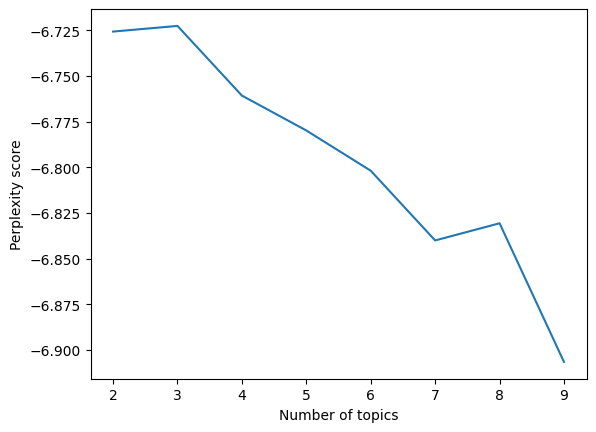

In [44]:
x = range(2, MAX_TOPIC)
plt.plot(x, perplexity_values)
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

## B. Coherence - 높을수록 좋음

In [45]:
coherence_values = []
for i in range(2, MAX_TOPIC):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, random_state=42)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=terms, dictionary=dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

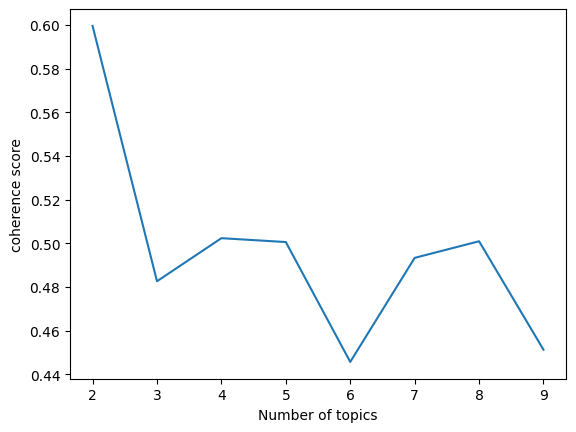

In [46]:
x = range(2, MAX_TOPIC)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

최종적으로 Perplexity와 Coherence Score를 동시에 고려하여 최적의 주제 수를 선택

## I. 최종 LDA 분석

In [47]:
print(coherence_values.index(max(coherence_values)) + 2)

2


In [48]:
FINAL_NUM_TOPICS = coherence_values.index(max(coherence_values)) + 2

In [49]:
final_model = gensim.models.LdaModel(
    corpus,
    num_topics=FINAL_NUM_TOPICS, # 출력 토픽 수
    id2word=dictionary,
    random_state=42
)

In [50]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
final_model.show_topics(4, 10)

[(0,
  '0.028*"소식" + 0.020*"뉴스" + 0.018*"최초" + 0.011*"고" + 0.011*"한국인" + 0.010*"진행" + 0.009*"의원" + 0.008*"위원장" + 0.007*"정말" + 0.007*"전재수"'),
 (1,
  '0.014*"뉴스" + 0.009*"최초" + 0.008*"한국인" + 0.008*"문학" + 0.008*"서울" + 0.007*"소식" + 0.007*"고" + 0.007*"올해" + 0.006*"선정" + 0.006*"지난"')]

In [51]:
TOP_N = 20

In [52]:
final_word_dict = {}
for i in range(FINAL_NUM_TOPICS):
  final_words = final_model.show_topic(i, topn=TOP_N)
  final_word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words]
  final_word_df = pd.DataFrame(final_word_dict)

In [53]:
final_word_df

,Topic #01,Topic #02
0,소식,뉴스
1,뉴스,최초
2,최초,한국인
3,고,문학
4,한국인,서울
5,진행,소식
6,의원,고
7,위원장,올해
8,정말,선정
9,전재수,지난


In [54]:
final_model.print_topics(num_words=5)

[(0, '0.028*"소식" + 0.020*"뉴스" + 0.018*"최초" + 0.011*"고" + 0.011*"한국인"'),
 (1, '0.014*"뉴스" + 0.009*"최초" + 0.008*"한국인" + 0.008*"문학" + 0.008*"서울"')]

In [55]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(9):
    print(final_model.get_document_topics(corpus)[i])

[(0, 0.94961005), (1, 0.050389897)]
[(0, 0.5887773), (1, 0.41122273)]
[(0, 0.9555039), (1, 0.044496052)]
[(0, 0.9725094), (1, 0.02749062)]
[(0, 0.6698728), (1, 0.33012718)]
[(0, 0.9632148), (1, 0.036785204)]
[(0, 0.65810084), (1, 0.34189913)]
[(0, 0.8981991), (1, 0.10180095)]
[(0, 0.65833604), (1, 0.34166393)]


## G. 최종 pyLDAvis 시각화

In [56]:
from IPython.display import HTML

pyLDAvis.enable_notebook()

#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data = pyLDAvis.gensim_models.prepare(final_model, corpus, dictionary)

final_data

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.035707  0.0       1        1  55.732689
1     -0.035707  0.0       2        1  44.267311, topic_info=     Term       Freq      Total Category  logprob  loglift
45     소식  86.000000  86.000000  Default  30.0000  30.0000
159    서울  21.000000  21.000000  Default  29.0000  29.0000
107    진행  31.000000  31.000000  Default  28.0000  28.0000
226   위원장  25.000000  25.000000  Default  27.0000  27.0000
115   민주당  19.000000  19.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
5      상금   7.973295  17.514813   Topic2  -5.5456   0.0280
581   초상화   7.657703  15.137530   Topic2  -5.5860   0.1335
99     기자   8.088258  21.472622   Topic2  -5.5313  -0.1614
184  대한민국   8.079241  22.264196   Topic2  -5.5324  -0.1988
4      발표   8.211990  25.431423   Topic2  -5.5161  -0.3155

[160 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
529       1  0.945780     가가
529       2  0.315260     가가
505       1  0.901166     가격
505       2  0.180233     가격
518       1  0.756800     가량
...     ...       ...    ...
273       2  0.626839   홈페이지
274       1  0.208355     활동
274       2  0.833420     활동
484       1  0.208319  휴머노이드
484       2  0.833275  휴머노이드

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [57]:
# HTML 파일로 저장
pyLDAvis.save_html(final_data, '../data/article_lda_vis.html')